In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from bokeh.palettes import inferno

# LOLIMOT (LOcal LInear MOdel Tree)
## Approximation einer eindimensionalen statischen Nichtlinearität: $\mathcal{NL}(u) = 3 \arctan(2u)$

__*Im folgenden Beispiel ist die Sturktur des model trees fest vorgegeben. In der vollständigen Implementierung liegen die Stützstellen nicht äquidistant, sondern werden im einem iterativen Prozess festgelegt!*__  

vlg. Schröder, Dierk und Buss, Martin: *Intelligente Verfahren: Identifikation und Regelung nichtlinearer Systeme*. S. 60ff, 2017

In [2]:
start_time = time.time()
M = 10 # Anzahl der Teilmodelle
N = 1 # Eingangsdimension
l = 101 # Anzahl der Stützstellen je Teilmodell (sollte ungerade sein)
k = 1000
sigma = 0.9
n = M*l-(M-1) # Gesamtzahl der benötigten Stützstellen
Sigma = np.ones((M, k, N)) * sigma
x_train = np.linspace(-5, 5, n)
u = np.linspace(-5, 5, k)
x_train_split = np.array([x_train[0+(l-1)*i:l+(l-1)*i] for i in range(M)])
xi = np.array([x_train_split[i][int(np.ceil(l/2))] for i in range(M)])

# Zu approximierende Nichtlinearität
def nl(u):
    return 3 * np.arctan(2*u)

def gerade(a,b,x):
    return a * x + b

Theta = np.zeros((M, N+1))

# Lineare Regression für jedes Teilmodell
for i in range(M):
    y = nl(x_train_split[i])
    X = np.array([x_train_split[i], np.ones_like(x_train_split[i])]).T
    theta_i = np.linalg.pinv(X) @ y
    Theta[i,:] = np.flip(theta_i, axis=0)
    
stop_time = time.time()
duration_1 = stop_time - start_time

Der Modellausgang $\hat{y}[k]$ berechnet sich für  
- M Teilmodelle mit dem 
- N-dimensionalen Eingangsvektor $\textbf{u}[k]$ und den
- Zugehörigkeitsfunktionen $\mathcal{A}_i$ zu:  
$$\hat{y} = \sum_{i=1}^M (\theta_{0,i} + \theta_{1,i} \cdot u_1 + \cdots + \theta_{N,i} \cdot u_N) \cdot \mathcal{A}_i(\textbf{u},\textbf{$\xi$}_i,\textbf{$\sigma$}_i)$$

__Zur Auswertung der approximierten Funktion $\hat{y}[k]$ an k Stellen muss die vorangegangene Formel durch Vektoren und Matrizen ausggedrückt werden:__

$N$ ... Anzahl der Dimensionen des Eingangsraums  
$M$ ... Anzahl der (linearen) Teilmodelle  
$k \in  \mathbb {N}_0$ ... k-ter Punkt des Eingangsraums   
  
$\hat{\textbf{y}} \in \mathbb {R}^k$ ... Ausgangsvektor für k Punkte  
$U \in \mathbb {R}^{k \times N}$ ... Matrix der Eingangswerte  

$\Theta = \begin{bmatrix} 
                \theta_{0,1} & \theta_{1,1} & \cdots & \theta_{N,1} \\
                \theta_{0,2} & \theta_{1,2} & \cdots & \theta_{N,2} \\
                \vdots & \vdots & \ddots & \vdots                   \\
                \theta_{0,M} & \theta_{1,M} & \cdots & \theta_{N,M}
            \end{bmatrix} \in \mathbb {R}^{M \times N+1}$ ... Matrix der Parameter der lokalen linearen Modelle      
 
$U^* = \begin{bmatrix}
                1 & 1 & \cdots & 1 \\
                u_{0,1} & u_{1,1} & \cdots & u_{k,1} \\
                u_{0,2} & u_{1,2} & \cdots & u_{k,2} \\
                \vdots & \vdots & \ddots & \vdots \\ 
                u_{0,N} & u_{1,N} & \cdots & u_{k,N}
            \end{bmatrix}    \in \mathbb {R}^{k \times N+1}$ ... Erweiterte Matrix der Eingangswerte  
             
$A = \begin{bmatrix}
                \mathcal{A}_{0,1} & \mathcal{A}_{1,1} & \cdots & \mathcal{A}_{k,1} \\
                \mathcal{A}_{0,2} & \mathcal{A}_{1,2} & \cdots & \mathcal{A}_{k,2} \\
                \vdots & \vdots & \ddots & \vdots \\ 
                \mathcal{A}_{0,M} & \mathcal{A}_{1,M} & \cdots & \mathcal{A}_{k,M}
            \end{bmatrix} \in \mathbb {R}^{M \times k}$ ... Matrix der Zugehörigkeitsfunktionen
            
$\Xi = \begin{bmatrix}
            \xi_{1,1} & \xi_{1,2} & \cdots & \xi_{1,M} \\
            \xi_{2,1} & \xi_{2,2} & \cdots & \xi_{2,M} \\
            \vdots & \vdots & \ddots & \vdots \\ 
            \xi_{N,1} & \xi_{N,2} & \cdots & \xi_{N,M} \\
        \end{bmatrix} \in \mathbb {R}^{N \times M}$ ... Matrix der Stützstellen

In [3]:
start_time = time.time()

U = np.reshape(u, (k,N))
print(f"U: {U.shape} >> k x N")
Xi = np.reshape(np.repeat([xi], k, axis=0).T, (M,k,1))
print(f"Xi: {Xi.shape} >> M x k x 1")
U_ext = np.broadcast_to(U, (M,k,N))
print(f"U_ext: {U_ext.shape} >> M x k x N")

c = U_ext-Xi
C = c**2 * np.reciprocal(Sigma)**2
mu = np.exp(-0.5 * np.sum(C, axis=2)) # Summation entlang N-Achse -> Mxk

print(f"mu: {mu.shape}")
mu_sum = np.sum(mu, axis=0) # Summation entlang M-Achse -> k
print(f"mu_sum: {mu_sum.shape}")

A = mu / mu_sum
print(f"A: {A.shape} >> M x k")
assert abs(np.sum(A, axis=0)[0] - 1) < 10**(-10) # Summe der Zugehörigkeitsfunktionen muss an jeder Stelle gleich Eins sein

U_star = np.hstack((np.ones((k,1)), U)).T
print(f"U_start: {U_star.shape}")

y_hat = np.sum((Theta @ U_star) * A, axis=0)

stop_time = time.time()
duration_2 = stop_time - start_time

U: (1000, 1) >> k x N
Xi: (10, 1000, 1) >> M x k x 1
U_ext: (10, 1000, 1) >> M x k x N
mu: (10, 1000)
mu_sum: (1000,)
A: (10, 1000) >> M x k
U_start: (2, 1000)


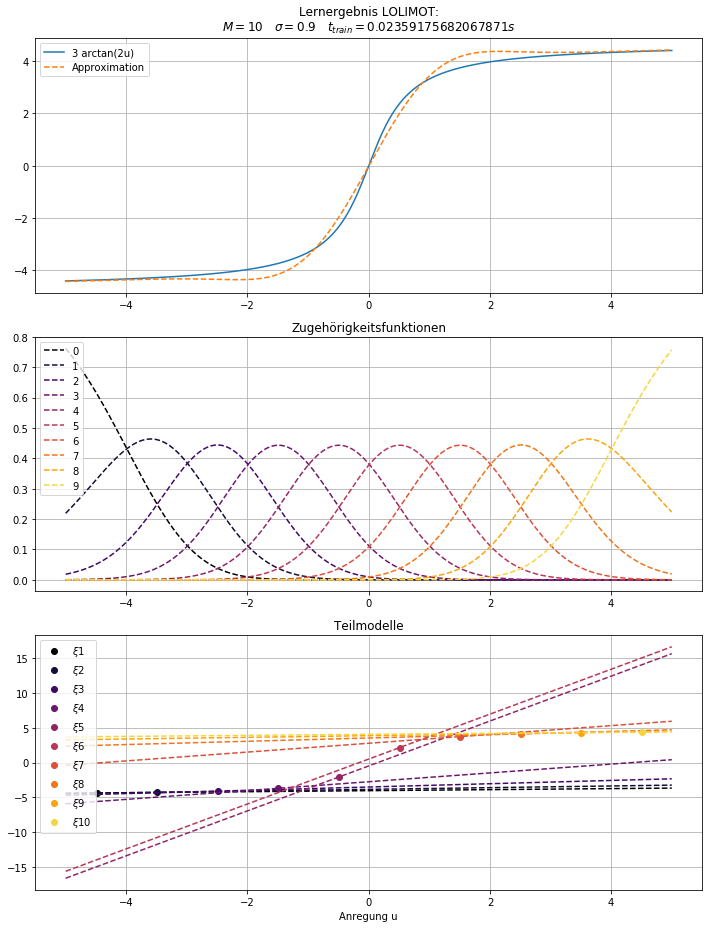

In [4]:
colors = inferno(M+1)
fig = plt.figure(figsize=(10, 13))

plt.subplot(3,1,1)
plt.title(f"Lernergebnis LOLIMOT:\n$M = {M} \quad \sigma = {sigma} \quad t_{{train}}={duration_1+duration_2}s$")
plt.grid(True)
plt.plot(u, nl(u), label=f"3 arctan(2u)")
plt.plot(u, y_hat, '--', label="Approximation")
plt.legend()

plt.subplot(3,1,2)
plt.title("Zugehörigkeitsfunktionen")
plt.grid(True)
for idx, column in enumerate(A):
    plt.plot(u, column, '--', label=f"{idx}", color=colors[idx])
plt.legend()

plt.subplot(3,1,3)
plt.title("Teilmodelle")
plt.grid(True)
plt.xlabel("Anregung u")
for idx, column in enumerate(Theta @ U_star):
    plt.plot(u, column, '--', color=colors[idx])
    plt.plot(xi[idx], gerade(*np.flip(Theta[idx], axis=0), xi[idx]), 'o', color=colors[idx], label=r"$\xi$" + str(idx+1))
    
plt.legend()  
    
plt.tight_layout()
plt.show()


__Fazit__: Da die Stützstellen äquidistant im Eingangsraum vorgegen wurden, ist die Approximation selbst für viele Teilmodelle mangelhaft.